# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

# Performance metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Loading the dataset

In [3]:
file_path = '/kaggle/input/ml-da-project/Global Land Temperatures By City.csv'

df = pd.read_csv(file_path)
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1900-01-01,-0.989,0.588,Århus,Denmark,57.05N,10.33E
1,1900-02-01,-2.799,0.882,Århus,Denmark,57.05N,10.33E
2,1900-03-01,0.592,0.429,Århus,Denmark,57.05N,10.33E
3,1900-04-01,4.630,0.417,Århus,Denmark,57.05N,10.33E
4,1900-05-01,9.576,0.521,Århus,Denmark,57.05N,10.33E


In [4]:
df.shape

(4791150, 7)

# Understanding the dataset

In [5]:
print("\nColumns in the dataset:\n")
list(df.columns)


Columns in the dataset:



['dt',
 'AverageTemperature',
 'AverageTemperatureUncertainty',
 'City',
 'Country',
 'Latitude',
 'Longitude']

In [6]:
print("\nInformation about each column:\n")
df.info()


Information about each column:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4791150 entries, 0 to 4791149
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       object 
 6   Longitude                      object 
dtypes: float64(2), object(5)
memory usage: 255.9+ MB


In [7]:
print("\nNo. of unique values in each column:\n")
df.nunique()


No. of unique values in each column:



dt                                1365
AverageTemperature               93355
AverageTemperatureUncertainty     3542
City                              3448
Country                            159
Latitude                            73
Longitude                         1227
dtype: int64

In [8]:
print("\nDescriptive analysis:\n")
df.describe().transpose()


Descriptive analysis:



,count,mean,std,min,25%,50%,75%,max
AverageTemperature,4788080.0,17.829039,10.033602,-42.704,12.072,20.207,25.803,39.156
AverageTemperatureUncertainty,4788080.0,0.443306,0.271315,0.034,0.269,0.372,0.535,7.568


# Data Preprocessing

## Handling the missing values

In [9]:
df.isnull().sum()

dt                                  0
AverageTemperature               3070
AverageTemperatureUncertainty    3070
City                                0
Country                             0
Latitude                            0
Longitude                           0
dtype: int64

**Deleting the rows containing null values as imputation can cause hindrance to the actual predictions.**

In [10]:
df.dropna(axis=0, inplace=True)

In [11]:
df.isnull().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
dtype: int64

## Feature Engineering

### Breaking down data column (dt) to year (Year) and month (Month) columns

In [12]:
df['dt'] = pd.to_datetime(df['dt'])

df['Year'] = df['dt'].dt.year
df['Month'] = df['dt'].dt.month

df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,Year,Month
0,1900-01-01,-0.989,0.588,Århus,Denmark,57.05N,10.33E,1900,1
1,1900-02-01,-2.799,0.882,Århus,Denmark,57.05N,10.33E,1900,2
2,1900-03-01,0.592,0.429,Århus,Denmark,57.05N,10.33E,1900,3
3,1900-04-01,4.630,0.417,Århus,Denmark,57.05N,10.33E,1900,4
4,1900-05-01,9.576,0.521,Århus,Denmark,57.05N,10.33E,1900,5


### Calculating Max and Min possible Average Temperature

In [13]:
df['MaxAvgTemp'] = df['AverageTemperature'] + df['AverageTemperatureUncertainty']
df['MinAvgTemp'] = df['AverageTemperature'] - df['AverageTemperatureUncertainty']

df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,Year,Month,MaxAvgTemp,MinAvgTemp
0,1900-01-01,-0.989,0.588,Århus,Denmark,57.05N,10.33E,1900,1,-0.401,-1.577
1,1900-02-01,-2.799,0.882,Århus,Denmark,57.05N,10.33E,1900,2,-1.917,-3.681
2,1900-03-01,0.592,0.429,Århus,Denmark,57.05N,10.33E,1900,3,1.021,0.163
3,1900-04-01,4.630,0.417,Århus,Denmark,57.05N,10.33E,1900,4,5.047,4.213
4,1900-05-01,9.576,0.521,Århus,Denmark,57.05N,10.33E,1900,5,10.097,9.055


### Locating the Hemisphere

In [14]:
mapping = {
    'NE': 'North Eastern',
    'NW': 'North Western',
    'SE': 'South Eastern',
    'SW': 'South Western'
}

df['Hemisphere'] = (df['Latitude'].str[-1] + df['Longitude'].str[-1]).map(mapping)
df['Hemisphere'].value_counts()

Hemisphere
North Eastern    2983068
North Western     967516
South Western     437844
South Eastern     399652
Name: count, dtype: int64

## Dropping unwanted columns

In [15]:
columns_to_drop = ['dt', 'AverageTemperatureUncertainty']
df = df.drop(columns=columns_to_drop, axis=1)

df.head()

,AverageTemperature,City,Country,Latitude,Longitude,Year,Month,MaxAvgTemp,MinAvgTemp,Hemisphere
0,-0.989,Århus,Denmark,57.05N,10.33E,1900,1,-0.401,-1.577,North Eastern
1,-2.799,Århus,Denmark,57.05N,10.33E,1900,2,-1.917,-3.681,North Eastern
2,0.592,Århus,Denmark,57.05N,10.33E,1900,3,1.021,0.163,North Eastern
3,4.630,Århus,Denmark,57.05N,10.33E,1900,4,5.047,4.213,North Eastern
4,9.576,Århus,Denmark,57.05N,10.33E,1900,5,10.097,9.055,North Eastern


## Encoding

In [16]:
city_encoder = LabelEncoder()
df['City'] = city_encoder.fit_transform(df['City'])

country_encoder = LabelEncoder()
df['Country'] = country_encoder.fit_transform(df['Country'])

hemisphere_encoder = LabelEncoder()
df['Hemisphere'] = hemisphere_encoder.fit_transform(df['Hemisphere'])

df.head()

,AverageTemperature,City,Country,Latitude,Longitude,Year,Month,MaxAvgTemp,MinAvgTemp,Hemisphere
0,-0.989,3443,39,57.05N,10.33E,1900,1,-0.401,-1.577,0
1,-2.799,3443,39,57.05N,10.33E,1900,2,-1.917,-3.681,0
2,0.592,3443,39,57.05N,10.33E,1900,3,1.021,0.163,0
3,4.630,3443,39,57.05N,10.33E,1900,4,5.047,4.213,0
4,9.576,3443,39,57.05N,10.33E,1900,5,10.097,9.055,0


# Data Visualization

In [17]:
df_vis = df.copy()
df_vis.head()

,AverageTemperature,City,Country,Latitude,Longitude,Year,Month,MaxAvgTemp,MinAvgTemp,Hemisphere
0,-0.989,3443,39,57.05N,10.33E,1900,1,-0.401,-1.577,0
1,-2.799,3443,39,57.05N,10.33E,1900,2,-1.917,-3.681,0
2,0.592,3443,39,57.05N,10.33E,1900,3,1.021,0.163,0
3,4.630,3443,39,57.05N,10.33E,1900,4,5.047,4.213,0
4,9.576,3443,39,57.05N,10.33E,1900,5,10.097,9.055,0


In [18]:
df = df.drop(columns=['Latitude', 'Longitude'], axis=1)
df.head()

,AverageTemperature,City,Country,Year,Month,MaxAvgTemp,MinAvgTemp,Hemisphere
0,-0.989,3443,39,1900,1,-0.401,-1.577,0
1,-2.799,3443,39,1900,2,-1.917,-3.681,0
2,0.592,3443,39,1900,3,1.021,0.163,0
3,4.630,3443,39,1900,4,5.047,4.213,0
4,9.576,3443,39,1900,5,10.097,9.055,0


### Correlation heatmap

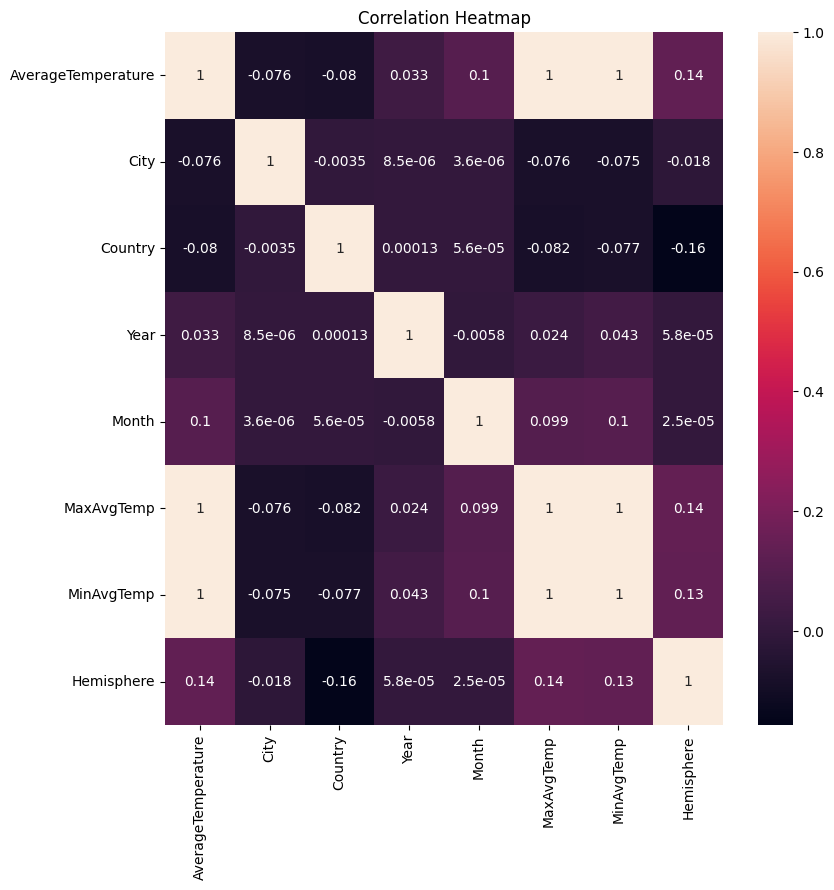

In [19]:
plt.figure(figsize=[9, 9])

sns.heatmap(
    df_vis[['AverageTemperature', 'City', 'Country', 'Year', 
            'Month', 'MaxAvgTemp', 'MinAvgTemp', 'Hemisphere']].corr(), 
    annot=True
)

plt.title('Correlation Heatmap')

plt.show()

### Decoding data for further visualization

In [20]:
df_vis['City'] = city_encoder.inverse_transform(df_vis['City'])
df_vis['Country'] = country_encoder.inverse_transform(df_vis['Country'])
df_vis['Hemisphere'] = hemisphere_encoder.inverse_transform(df_vis['Hemisphere'])

df_vis.head()

,AverageTemperature,City,Country,Latitude,Longitude,Year,Month,MaxAvgTemp,MinAvgTemp,Hemisphere
0,-0.989,Århus,Denmark,57.05N,10.33E,1900,1,-0.401,-1.577,North Eastern
1,-2.799,Århus,Denmark,57.05N,10.33E,1900,2,-1.917,-3.681,North Eastern
2,0.592,Århus,Denmark,57.05N,10.33E,1900,3,1.021,0.163,North Eastern
3,4.630,Århus,Denmark,57.05N,10.33E,1900,4,5.047,4.213,North Eastern
4,9.576,Århus,Denmark,57.05N,10.33E,1900,5,10.097,9.055,North Eastern


### Country-wise Average Temperature

**Finding the mean temperature of each country.**

/opt/conda/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


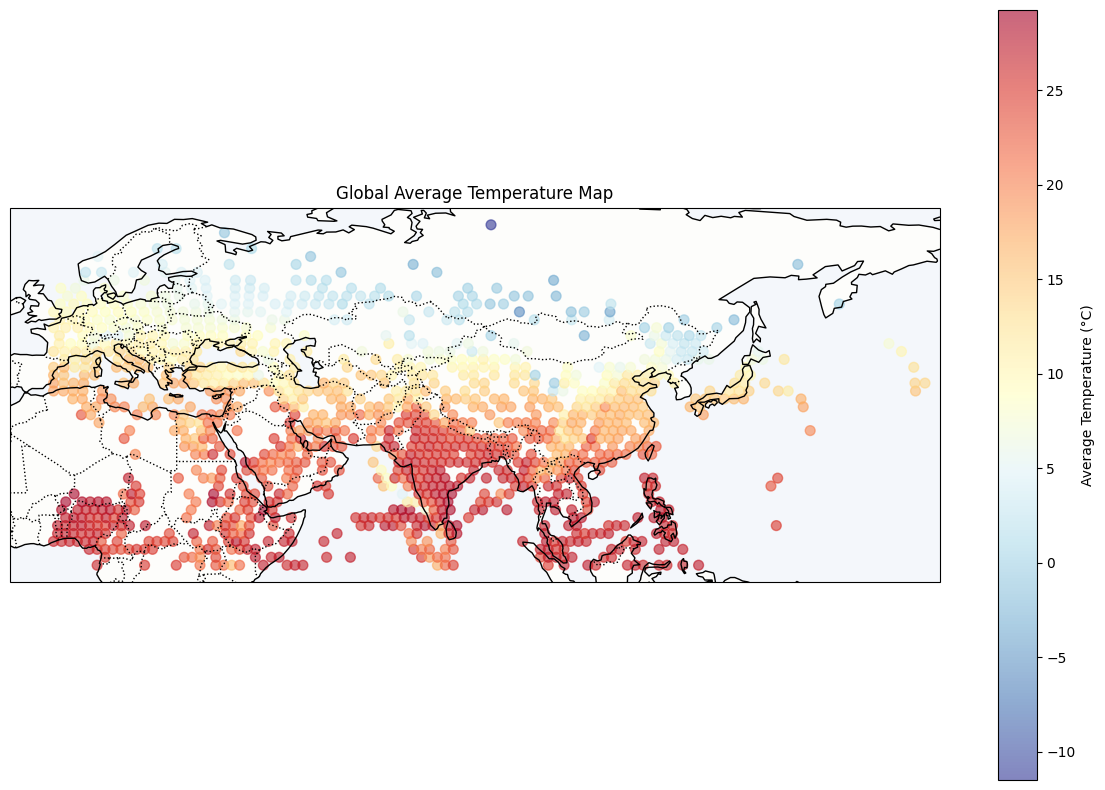

In [21]:
def create_temperature_heatmap(df_vis):
    # Clean and convert Latitude
    df_vis['Latitude'] = (
        df_vis['Latitude']
        .str.replace(r'[^0-9.-]', '', regex=True)
        .astype(float)
    )
    
    # Clean and convert Longitude
    df_vis['Longitude'] = (
        df_vis['Longitude']
        .str.replace(r'[^0-9.-]', '', regex=True)  # Remove non-numeric characters except '-' and '.'
        .astype(float)
    )
    
    # Drop rows with invalid coordinates
    df_vis = df_vis.dropna(subset=['Latitude', 'Longitude'])
    
    # Calculate mean temperature for each location
    avg_temps = df_vis.groupby(['Latitude', 'Longitude'])['AverageTemperature'].mean().reset_index()
    
    # Create the plot with cartopy
    fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, alpha=0.1)
    ax.add_feature(cfeature.OCEAN, alpha=0.1)
    
    # Create scatter plot with temperature colors
    scatter = ax.scatter(
        avg_temps['Longitude'], avg_temps['Latitude'],
        c=avg_temps['AverageTemperature'],
        cmap='RdYlBu_r',
        transform=ccrs.PlateCarree(),
        alpha=0.6,
        s=50
    )
    
    plt.colorbar(scatter, label='Average Temperature (°C)')
    plt.title('Global Average Temperature Map')
    plt.show()

create_temperature_heatmap(df_vis)

### Country-wise Min, Max, Average Temperature

In [22]:
temp_compare = df_vis[['Country', 'AverageTemperature', 'MaxAvgTemp', 'MinAvgTemp']].groupby(['Country']).mean()
temp_compare.sort_values(by='AverageTemperature', inplace=True)

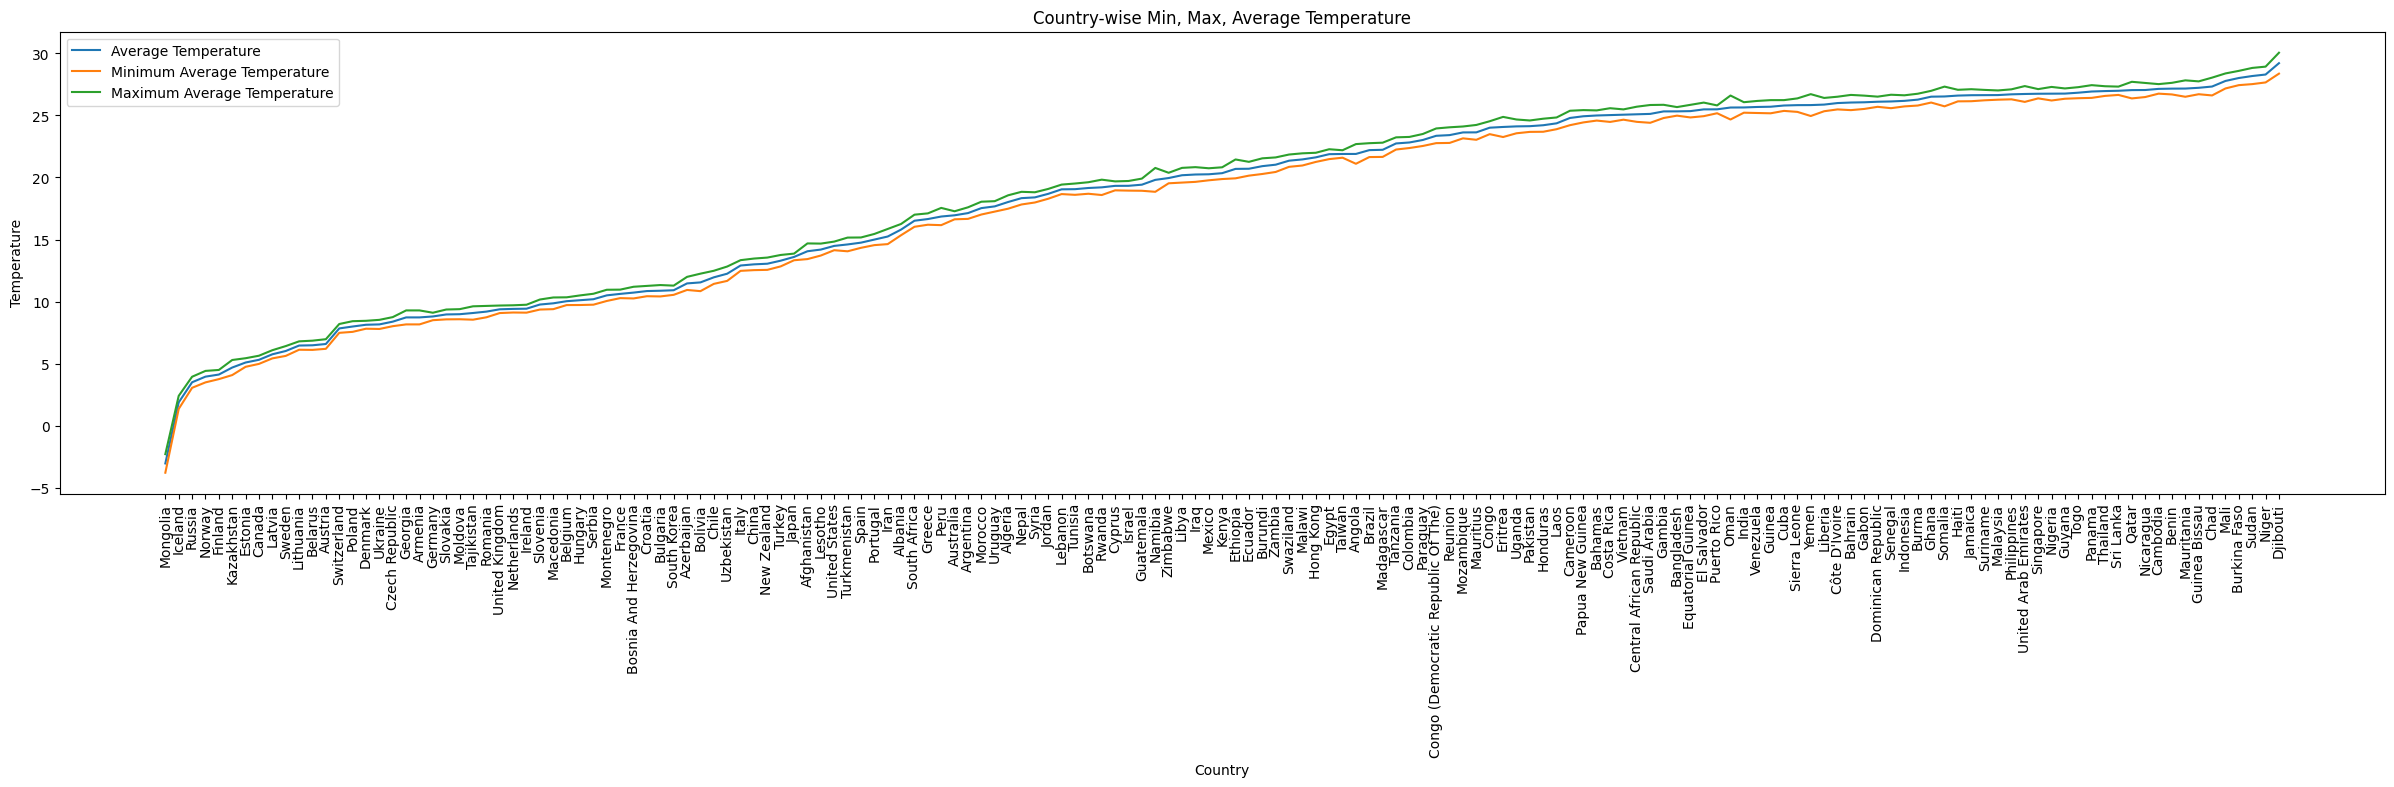

In [23]:
plt.figure(figsize=[30, 6])

sns.lineplot(x=temp_compare.index, y=temp_compare['AverageTemperature'], label='Average Temperature')
sns.lineplot(x=temp_compare.index, y=temp_compare['MinAvgTemp'], label='Minimum Average Temperature')
sns.lineplot(x=temp_compare.index, y=temp_compare['MaxAvgTemp'], label='Maximum Average Temperature')

plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Temperature')
plt.title('Country-wise Min, Max, Average Temperature')
plt.legend()

plt.show()

### Hemisphere-wise Average Temperature

In [24]:
hemisphere_compare = df_vis[['Hemisphere', 'AverageTemperature']].groupby(['Hemisphere']).mean()

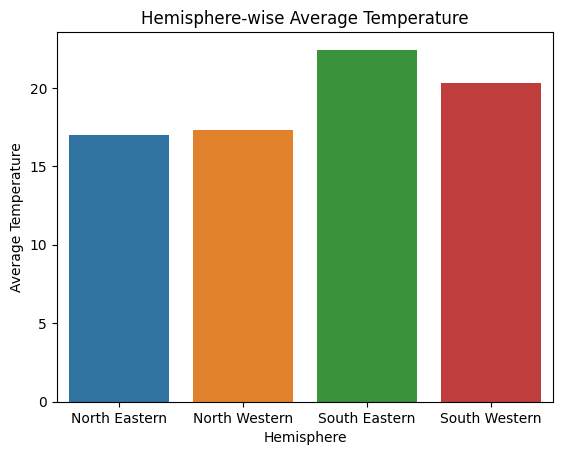

In [25]:
sns.barplot(x=hemisphere_compare.index, y=hemisphere_compare['AverageTemperature'])

plt.xlabel('Hemisphere')
plt.ylabel('Average Temperature')
plt.title('Hemisphere-wise Average Temperature')

plt.show()

### Change in Temperature in every quarter of a century (25 years)

In [26]:
interval_map = {
    1900: '1900-1924',
    1925: '1925-1949',
    1950: '1950-1974',
    1975: '1975-1999',
    2000: '2000-2024'
}

In [27]:
interval_temp = df_vis[['Year', 'AverageTemperature']].copy()
interval_temp['Year Interval'] = ((interval_temp['Year'] // 25) * 25).map(interval_map)

interval_temp = interval_temp.groupby(['Year Interval']).mean()
interval_temp.sort_values(by='AverageTemperature', inplace=True)

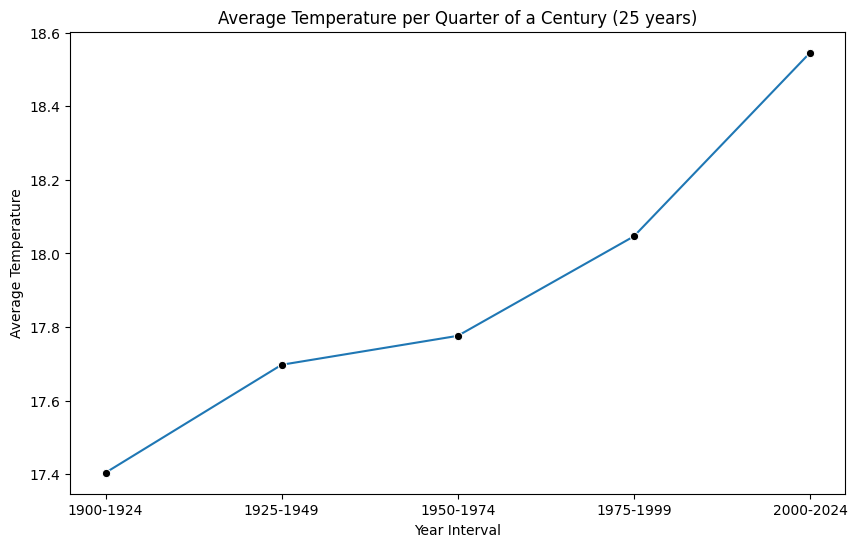

In [28]:
plt.figure(figsize=[10, 6])

sns.lineplot(
    x=interval_temp.index, 
    y=interval_temp['AverageTemperature'], 
    marker='o', 
    markerfacecolor='black', 
    markersize=6
)

plt.xlabel('Year Interval')
plt.ylabel('Average Temperature')
plt.title('Average Temperature per Quarter of a Century (25 years)')

plt.show()

### Change in Temperature in every decade (10 years)

In [29]:
interval_map = {
    1900: '1900-1909',
    1910: '1910-1919',
    1920: '1920-1929',
    1930: '1930-1939',
    1940: '1940-1949',
    1950: '1950-1959',
    1960: '1960-1969',
    1970: '1970-1979',
    1980: '1980-1989',
    1990: '1990-1999',
    2000: '2000-2009',
    2010: '2010-2019',
    2020: '2020-2024'
}

In [30]:
interval_temp = df_vis[['Year', 'AverageTemperature']].copy()
interval_temp['Year Interval'] = ((interval_temp['Year'] // 10) * 10).map(interval_map)

interval_temp = interval_temp.groupby(['Year Interval']).mean()
interval_temp.sort_values(by='AverageTemperature', inplace=True)

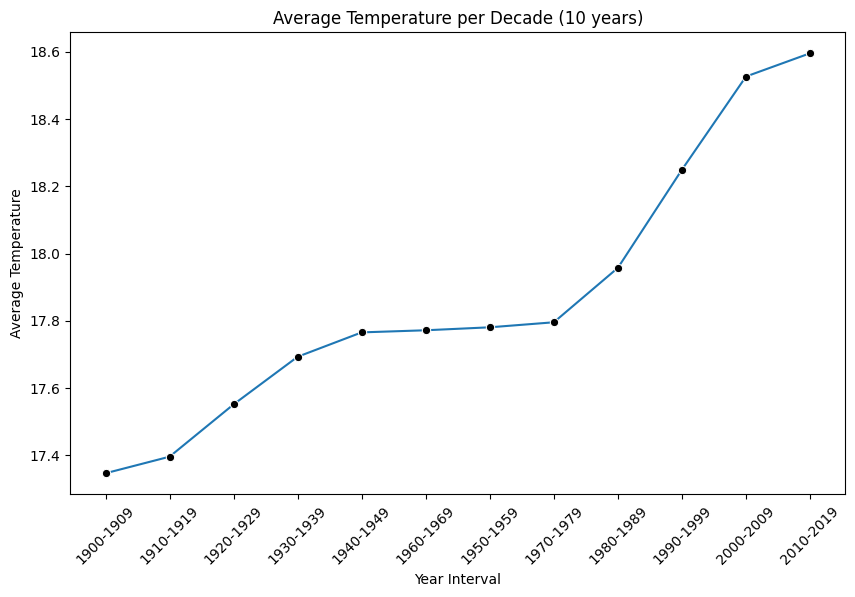

In [31]:
plt.figure(figsize=[10, 6])

sns.lineplot(
    x=interval_temp.index, 
    y=interval_temp['AverageTemperature'], 
    marker='o', 
    markerfacecolor='black', 
    markersize=6
)

plt.xticks(rotation=45)
plt.xlabel('Year Interval')
plt.ylabel('Average Temperature')
plt.title('Average Temperature per Decade (10 years)')

plt.show()

# X & y split

In [32]:
y = df['AverageTemperature']
x = df.drop(columns=['AverageTemperature'], axis=1)

In [33]:
x.head()

,City,Country,Year,Month,MaxAvgTemp,MinAvgTemp,Hemisphere
0,3443,39,1900,1,-0.401,-1.577,0
1,3443,39,1900,2,-1.917,-3.681,0
2,3443,39,1900,3,1.021,0.163,0
3,3443,39,1900,4,5.047,4.213,0
4,3443,39,1900,5,10.097,9.055,0


In [34]:
scaler = StandardScaler()
x_scaled = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

x_scaled.head()

,City,Country,Year,Month,MaxAvgTemp,MinAvgTemp,Hemisphere
0,1.724975,-0.893446,-1.716823,-1.591012,-1.861716,-1.887900,-0.661774
1,1.724975,-0.893446,-1.716823,-1.301131,-2.012860,-2.097371,-0.661774
2,1.724975,-0.893446,-1.716823,-1.011250,-1.719944,-1.714668,-0.661774
3,1.724975,-0.893446,-1.716823,-0.721369,-1.318555,-1.311457,-0.661774
4,1.724975,-0.893446,-1.716823,-0.431488,-0.815075,-0.829395,-0.661774


# Train & test split

In [35]:
x_train, x_test, y_train, y_test = train_test_split(
    x_scaled,
    y,
    test_size=0.3,
    random_state=42
)

In [36]:
print("Train shape:\n")
x_train.shape, y_train.shape

Train shape:



((3351656, 7), (3351656,))

In [37]:
print("Test shape:\n")
x_test.shape, y_test.shape

Test shape:



((1436424, 7), (1436424,))

# Model Building

### Lasso Linear Regression

In [38]:
lasso = Lasso()
lasso.fit(x_train, y_train)

Lasso()

In [39]:
lasso_pred = lasso.predict(x_test)

In [40]:
lasso_r2 = round(r2_score(y_test, lasso_pred), 3)
lasso_rmse = round(mean_squared_error(y_test, lasso_pred) ** 0.5, 5)
lasso_mae = round(mean_absolute_error(y_test, lasso_pred), 5)

print(f"\nR2 Score: {lasso_r2}")
print(f"RMSE: {lasso_rmse}")
print(f"MAE: {lasso_mae}\n\n")


R2 Score: 0.99
RMSE: 1.00027
MAE: 0.80095




### K Neighbors Regression

In [41]:
knn = KNeighborsRegressor()
knn.fit(x_train, y_train)

KNeighborsRegressor()

In [42]:
knn_pred = knn.predict(x_test)

In [43]:
knn_r2 = round(r2_score(y_test, knn_pred), 3)
knn_rmse = round(mean_squared_error(y_test, knn_pred) ** 0.5, 5)
knn_mae = round(mean_absolute_error(y_test, knn_pred), 5)

print(f"\nR2 Score: {knn_r2}")
print(f"RMSE: {knn_rmse}")
print(f"MAE: {knn_mae}\n\n")


R2 Score: 0.999
RMSE: 0.24528
MAE: 0.17294




### Decision Tree Regression

In [44]:
dtr = DecisionTreeRegressor(max_depth=6)
dtr.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=6)

In [45]:
dtr_pred = dtr.predict(x_test)

In [46]:
dtr_r2 = round(r2_score(y_test, dtr_pred), 3)
dtr_rmse = round(mean_squared_error(y_test, dtr_pred) ** 0.5, 5)
dtr_mae = round(mean_absolute_error(y_test, dtr_pred), 5)

print(f"\nR2 Score: {dtr_r2}")
print(f"RMSE: {dtr_rmse}")
print(f"MAE: {dtr_mae}\n\n")


R2 Score: 0.999
RMSE: 0.32277
MAE: 0.23846




### Random Forest Regression

In [47]:
rfr = RandomForestRegressor(max_depth=6, n_estimators=8)
rfr.fit(x_train, y_train)

RandomForestRegressor(max_depth=6, n_estimators=8)

In [48]:
rfr_pred = rfr.predict(x_test)

In [49]:
rfr_r2 = round(r2_score(y_test, rfr_pred), 3)
rfr_rmse = round(mean_squared_error(y_test, rfr_pred) ** 0.5, 5)
rfr_mae = round(mean_absolute_error(y_test, rfr_pred), 5)

print(f"\nR2 Score: {rfr_r2}")
print(f"RMSE: {rfr_rmse}")
print(f"MAE: {rfr_mae}\n\n")


R2 Score: 0.999
RMSE: 0.2829
MAE: 0.20671




### AdaBoost Regression

In [50]:
adaboost = AdaBoostRegressor()
adaboost.fit(x_train, y_train)

AdaBoostRegressor()

In [51]:
adaboost_pred = adaboost.predict(x_test)

In [52]:
adaboost_r2 = round(r2_score(y_test, adaboost_pred), 3)
adaboost_rmse = round(mean_squared_error(y_test, adaboost_pred) ** 0.5, 5)
adaboost_mae = round(mean_absolute_error(y_test, adaboost_pred), 5)

print(f"\nR2 Score: {adaboost_r2}")
print(f"RMSE: {adaboost_rmse}")
print(f"MAE: {adaboost_mae}\n\n")


R2 Score: 0.994
RMSE: 0.76775
MAE: 0.59275




### LGBM Regression

In [53]:
lgbm = LGBMRegressor()
lgbm.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.509375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1058
[LightGBM] [Info] Number of data points in the train set: 3351656, number of used features: 7
[LightGBM] [Info] Start training from score 17.825293


LGBMRegressor()

In [54]:
lgbm_pred = lgbm.predict(x_test)

In [55]:
lgbm_r2 = round(r2_score(y_test, lgbm_pred), 3)
lgbm_rmse = round(mean_squared_error(y_test, lgbm_pred) ** 0.5, 5)
lgbm_mae = round(mean_absolute_error(y_test, lgbm_pred), 5)

print(f"\nR2 Score: {lgbm_r2}")
print(f"RMSE: {lgbm_rmse}")
print(f"MAE: {lgbm_mae}\n\n")


R2 Score: 1.0
RMSE: 0.17682
MAE: 0.05141




### Arificial Neural Network

In [ ]:
FEATURES = x_train.shape[1]

ann = Sequential()
ann.add(Input(shape=(FEATURES,)))
ann.add(Dense(64, activation='relu'))
ann.add(Dense(1))
ann.compile(optimizer='adam', loss='mse', metrics=['r2_score'])
ann.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 577 (2.25 KB)

 Trainable params: 577 (2.25 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
ann.fit(x_train, y_train, epochs=5, batch_size=5096)

Epoch 1/5
658/658 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 215.4654 - r2_score: -1.1405
Epoch 2/5
658/658 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 4.1824 - r2_score: 0.9584
Epoch 3/5
658/658 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 2.0250 - r2_score: 0.9799
Epoch 4/5
658/658 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.7861 - r2_score: 0.9922
Epoch 5/5
658/658 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2434 - r2_score: 0.9976


In [58]:
ann_pred = ann.predict(x_test)

44889/44889 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step


In [59]:
ann_r2 = round(r2_score(y_test, ann_pred), 3)
ann_rmse = round(mean_squared_error(y_test, ann_pred) ** 0.5, 5)
ann_mae = round(mean_absolute_error(y_test, ann_pred), 5)

print(f"\nR2 Score: {ann_r2}")
print(f"RMSE: {ann_rmse}")
print(f"MAE: {ann_mae}\n\n")


R2 Score: 0.999
RMSE: 0.37671
MAE: 0.28419




# Performance Comparison

In [60]:
models = [
    'Lasso Regression',
    'K Neighbors Regression',
    'Decision Tree Regression',
    'Random Forest Regression',
    'AdaBoost Regression',
    'LGBM Regression',
    'Artificial Neural Network'
]

r2_scores = [lasso_r2, knn_r2, dtr_r2, rfr_r2, adaboost_r2, lgbm_r2, ann_r2]
rmses = [lasso_rmse, knn_rmse, dtr_rmse, rfr_rmse, adaboost_rmse, lgbm_rmse, ann_rmse]
maes = [lasso_mae, knn_mae, dtr_mae, rfr_mae, adaboost_mae, lgbm_mae, ann_mae]

In [61]:
performance_metrics = pd.DataFrame({
    'Model': models,
    'R2 Score': r2_scores,
    'Root Mean Square Error': rmses,
    'Mean Absolute Error': maes
})

performance_metrics

,Model,R2 Score,Root Mean Square Error,Mean Absolute Error
0,Lasso Regression,0.990,1.00027,0.80095
1,K Neighbors Regression,0.999,0.24528,0.17294
2,Decision Tree Regression,0.999,0.32277,0.23846
3,Random Forest Regression,0.999,0.28290,0.20671
4,AdaBoost Regression,0.994,0.76775,0.59275
5,LGBM Regression,1.000,0.17682,0.05141
6,Artificial Neural Network,0.999,0.37671,0.28419


### R2 Score Comparison

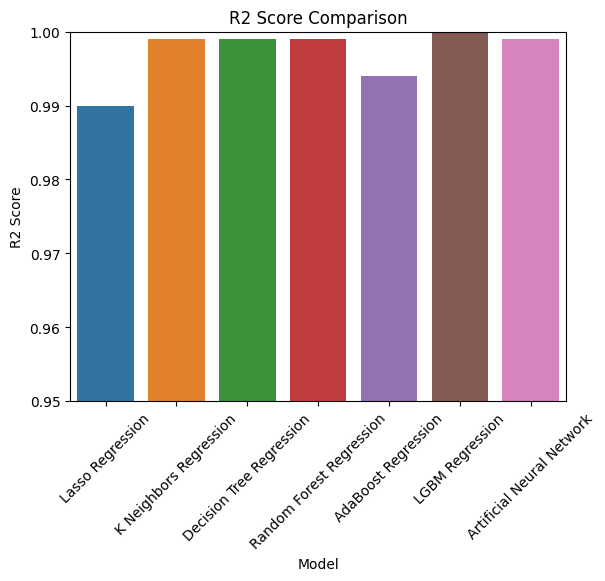

In [62]:
sns.barplot(x=performance_metrics['Model'], y=performance_metrics['R2 Score'])

plt.ylim(0.95, 1.0)
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.title('R2 Score Comparison')

plt.show()

### Root Mean Square Error Comparison

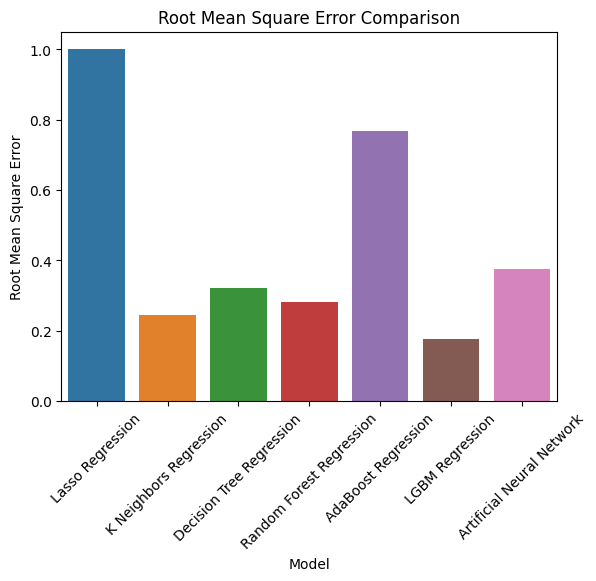

In [63]:
sns.barplot(x=performance_metrics['Model'], y=performance_metrics['Root Mean Square Error'])

plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('Root Mean Square Error')
plt.title('Root Mean Square Error Comparison')

plt.show()

### Mean Absolute Error Comparison

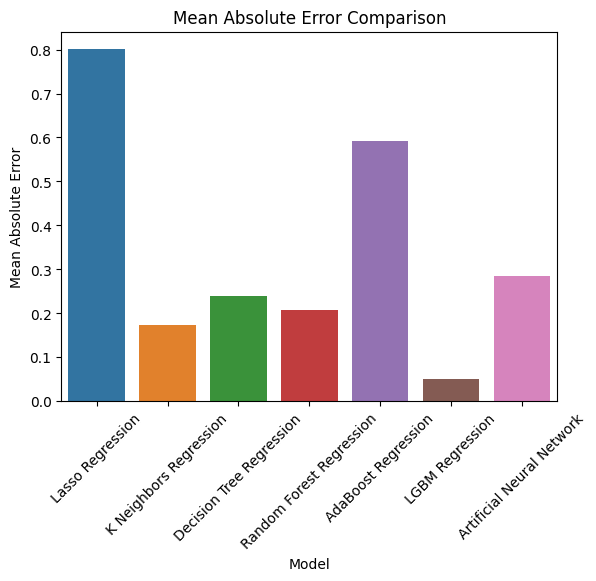

In [64]:
sns.barplot(x=performance_metrics['Model'], y=performance_metrics['Mean Absolute Error'])

plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error Comparison')

plt.show()